<a href="https://colab.research.google.com/github/VitaT/ML-python/blob/main/Fish_11_23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FISH weight prediction

Task -- make a regression model to predict fish weight using other predictors.

In [6]:
import matplotlib.pyplot as plt   # visualization
import seaborn as sns             # visualization
import numpy as np                # data manipulation
import pandas as pd               # data manipulation, data processing, CSV file I/O (e.g. pd.read_csv
# from sklearn import datasets, model_selection
# import statsmodels.api as sm
# import statsmodels.formula.api as smf
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso, LassoCV, Ridge, RidgeCV, LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.model_selection import KFold, StratifiedKFold, LeaveOneOut, cross_val_score, cross_validate, GridSearchCV, train_test_split

# load data
url="https://raw.githubusercontent.com/VitaT/ML-python/main/data/fish.csv"
data = pd.read_csv(url)

In [7]:
# Checking data
data.info()
data.head(5)
data.sample(10)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147 entries, 0 to 146
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Species  147 non-null    object 
 1   Weight   147 non-null    float64
 2   Length1  147 non-null    float64
 3   Length2  147 non-null    float64
 4   Length3  147 non-null    float64
 5   Height   147 non-null    float64
 6   Width    147 non-null    float64
dtypes: float64(6), object(1)
memory usage: 8.2+ KB


,Species,Weight,Length1,Length2,Length3,Height,Width
136,Smelt,7.5,10.0,10.5,11.6,1.9720,1.1600
67,Perch,32.0,12.5,13.7,14.7,3.5280,1.9992
96,Perch,265.0,25.4,27.5,28.9,7.0516,4.3350
95,Perch,260.0,25.4,27.5,28.9,7.1672,4.3350
49,Roach,390.0,29.5,31.7,35.0,9.4850,5.3550
20,Bream,680.0,31.8,35.0,40.6,15.4686,6.1306
117,Perch,1000.0,40.2,43.5,46.0,12.6040,8.1420
80,Perch,120.0,20.0,22.0,23.5,6.1100,3.4075
37,Roach,120.0,19.4,21.0,23.7,6.1146,3.2943
145,Smelt,19.7,13.2,14.3,15.2,2.8728,2.0672


Meanings of the Columns:

*  Species   (Numeric)

Code |Finnish     |English        |Latin      
--- | --- | --- | ---
1    |Lahna       |Bream          |Abramis brama
2    |Siika       |Whitewish      |Leusiscus idus
3    |Saerki      |Roach          |Leuciscus rutilus
4    |Parkki      |?              |Abramis bjrkna
5    |Norssi      |Smelt          |Osmerus eperlanus
6    |Hauki       |Pike           |Esox lucius
7    |Ahven       |Perch          |Perca fluviatilis

*  Weight      Weight of the fish (in grams)
*  Length1     Length from the nose to the beginning of the tail (in cm)
*  Length2     Length from the nose to the notch of the tail (in cm)
*  Length3     Length from the nose to the end of the tail (in cm)
*  Height    Maximal height as % of Length3
*  Width      Maximal width as % of Length3




# Data exploration

In [8]:
# checking for missing values
data.isnull().values.any()

False

Text(0, 0.5, 'Counts of Species')

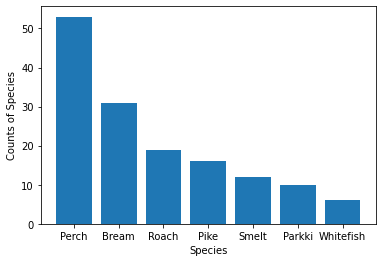

In [9]:
# exploring species distribution
sp = data["Species"].value_counts()
plt.bar(sp.index, sp, width=0.8)
plt.xlabel('Species')
plt.ylabel('Counts of Species')

In [10]:
# Dataset statistics
data.describe()

,Weight,Length1,Length2,Length3,Height,Width
count,147.000000,147.000000,147.000000,147.000000,147.000000,147.00000
mean,403.595238,26.418367,28.604082,31.397959,8.951939,4.45003
std,364.152888,10.119126,10.837479,11.709401,4.225641,1.68695
min,0.000000,7.500000,8.400000,8.800000,1.728400,1.04760
25%,120.000000,19.200000,21.000000,23.200000,6.031600,3.40895
50%,290.000000,25.200000,27.300000,29.400000,7.786000,4.30560
75%,650.000000,33.150000,36.000000,40.150000,12.143400,5.65830
max,1650.000000,59.000000,63.400000,68.000000,18.957000,8.14200


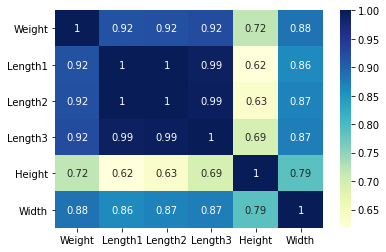

In [11]:
# correlation
data_cor = data.corr()
data_cor
sns.heatmap(data_cor, annot = True, cmap = "YlGnBu")
# Length1,2,3 values are highly correlated -- likely won't add more information if all are included
# Likely informational predictors -- width, height, one of the Length and Species?

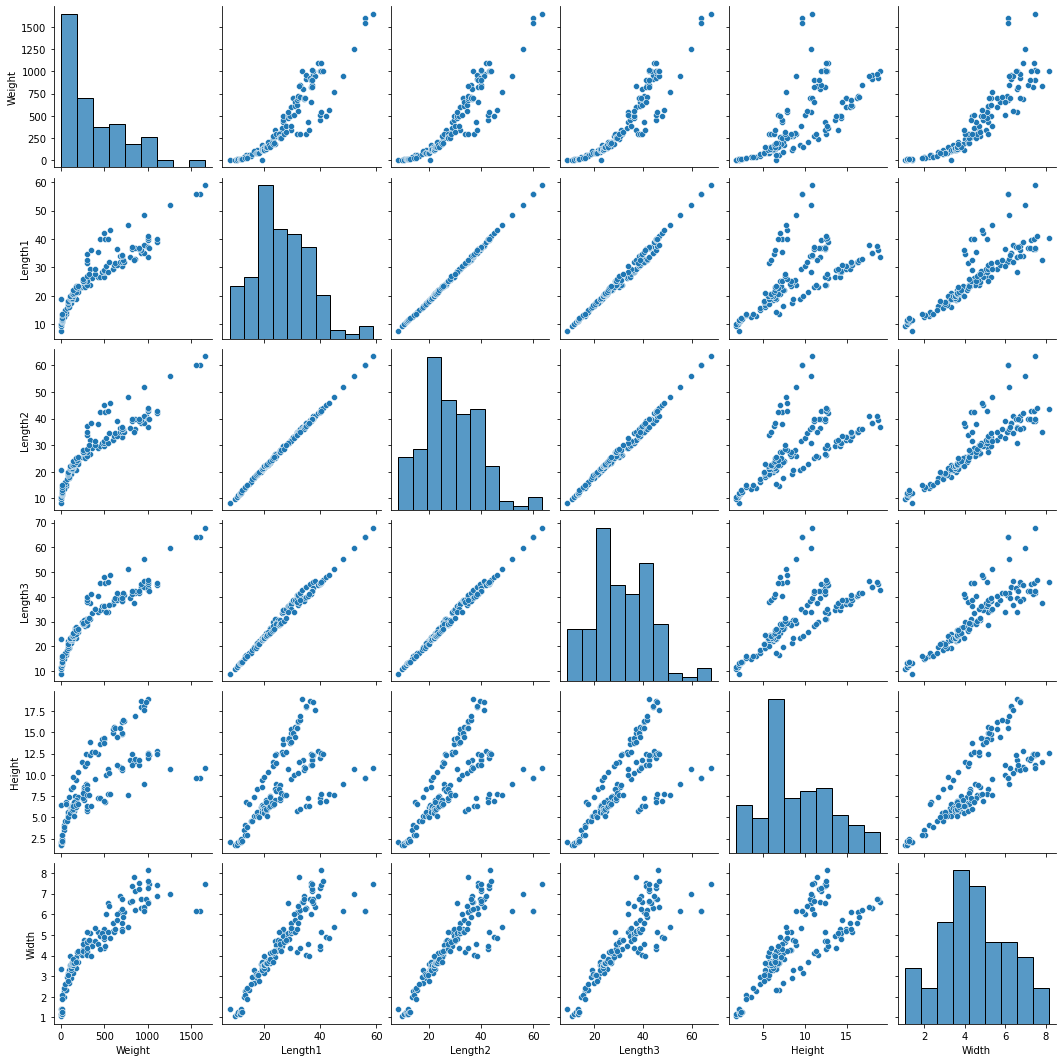

In [670]:
sns.pairplot(data)

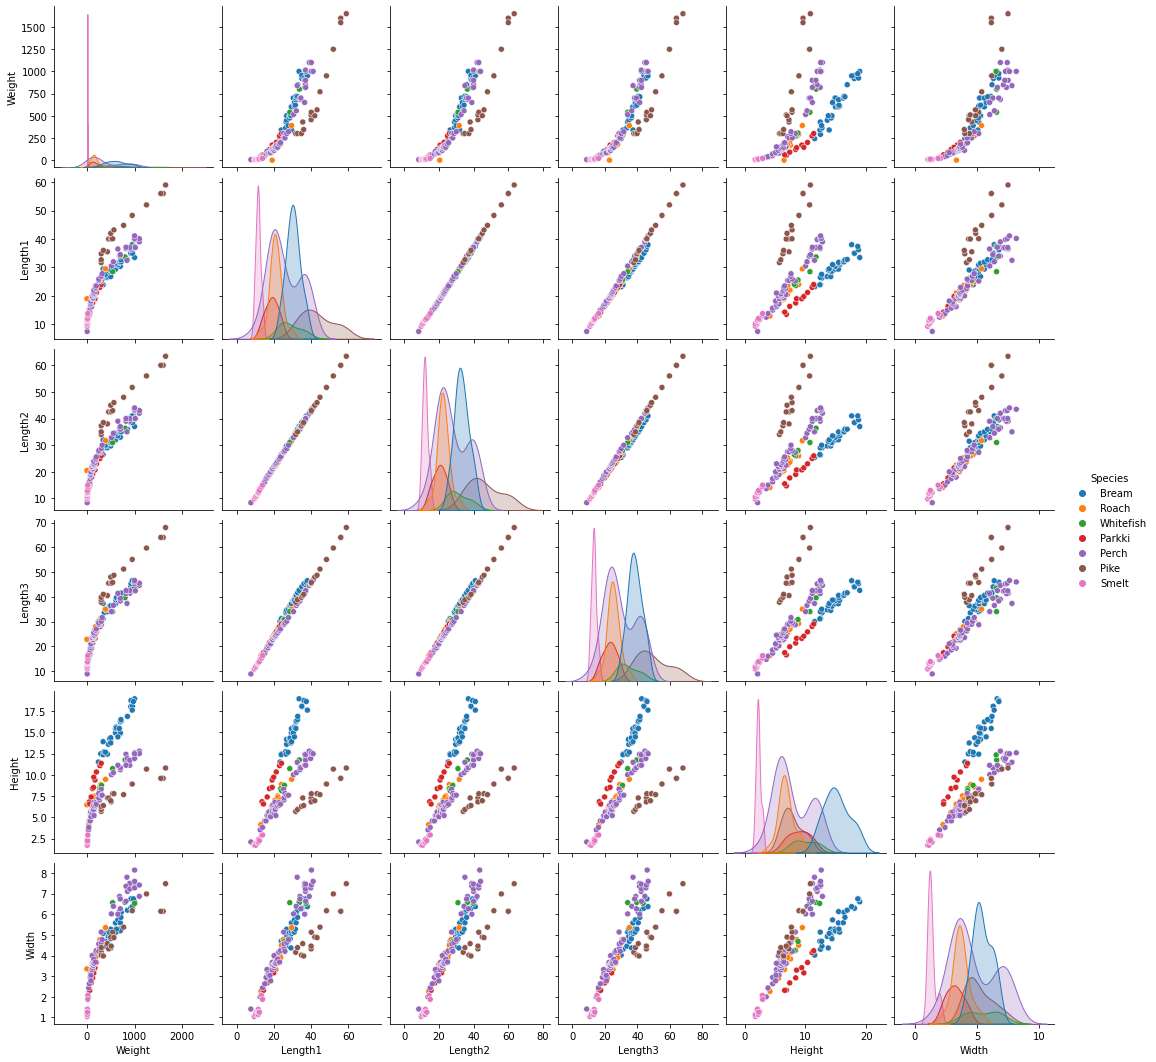

In [671]:
sns.pairplot(data, hue = "Species")

In [12]:
# yes, species will likely be an informational predictor
data.groupby('Species').mean()

,Weight,Length1,Length2,Length3,Height,Width
Species,,,,,,
Bream,619.000000,30.277419,33.090323,38.312903,15.158884,5.423535
Parkki,155.300000,18.760000,20.380000,22.830000,8.969390,3.213530
Perch,382.498113,25.652830,27.820755,29.494340,7.834566,4.745791
Pike,751.125000,43.256250,46.306250,49.587500,7.847881,5.193306
Roach,156.421053,20.863158,22.489474,25.215789,6.768295,3.701858
Smelt,11.508333,11.366667,12.050000,13.158333,2.229750,1.341342
Whitefish,531.000000,28.800000,31.316667,34.316667,10.027167,5.473050


Skewness: 1.106843
Kurtosis: 0.829207


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


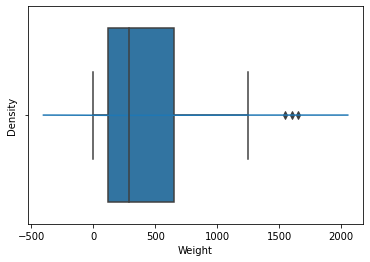

In [13]:
# Does weight has possible outliers?
sns.boxplot(x=data['Weight'])
sns.distplot(x=data['Weight'])
#skewness and kurtosis
print("Skewness: %f" % data['Weight'].skew())
print("Kurtosis: %f" % data['Weight'].kurt())

In [14]:
# identifying outliers with Interquartile Rule (IQR * 1.5)
# finding the ranges
dfw = data['Weight']
dfw_Q1 = dfw.quantile(0.25)
dfw_Q3 = dfw.quantile(0.75)
dfw_IQR = dfw_Q3 - dfw_Q1
dfw_lowerend = dfw_Q1 - (1.5 * dfw_IQR)
dfw_upperend = dfw_Q3 + (1.5 * dfw_IQR)
# identifying the points
out_id = (dfw < dfw_lowerend) | (dfw > dfw_upperend)
data[out_id]

,Species,Weight,Length1,Length2,Length3,Height,Width
132,Pike,1600.0,56.0,60.0,64.0,9.600,6.144
133,Pike,1550.0,56.0,60.0,64.0,9.600,6.144
134,Pike,1650.0,59.0,63.4,68.0,10.812,7.480


In [15]:
# outliers for other columns independently
q1 = data.quantile(0.25)
q3 = data.quantile(0.75)
iqr = q3 - q1
data_out_id = (data < (q1 -1.5 * iqr)) | (data > (q3 + 1.5 * iqr))
for i in data_out_id.columns:
  print(i)
  print(data[data_out_id.loc[:, i]])

# we could treat 142, 143, 144 as outliers

Height
Empty DataFrame
Columns: [Species, Weight, Length1, Length2, Length3, Height, Width]
Index: []
Length1
    Species  Weight  Length1  Length2  Length3  Height  Width
132    Pike  1600.0     56.0     60.0     64.0   9.600  6.144
133    Pike  1550.0     56.0     60.0     64.0   9.600  6.144
134    Pike  1650.0     59.0     63.4     68.0  10.812  7.480
Length2
    Species  Weight  Length1  Length2  Length3  Height  Width
132    Pike  1600.0     56.0     60.0     64.0   9.600  6.144
133    Pike  1550.0     56.0     60.0     64.0   9.600  6.144
134    Pike  1650.0     59.0     63.4     68.0  10.812  7.480
Length3
    Species  Weight  Length1  Length2  Length3  Height  Width
134    Pike  1650.0     59.0     63.4     68.0  10.812   7.48
Species
Empty DataFrame
Columns: [Species, Weight, Length1, Length2, Length3, Height, Width]
Index: []
Weight
    Species  Weight  Length1  Length2  Length3  Height  Width
132    Pike  1600.0     56.0     60.0     64.0   9.600  6.144
133    Pike  1550.0 

In [16]:
# encode Species as dummy variables
y = data["Weight"]
x = pd.get_dummies(data, columns=["Species"]).drop("Weight", axis = 1)

Principal component analysis (PCA) is a statistical procedure that uses an orthogonal transformation to convert a set of observations of possibly correlated variables into a set of values of linearly uncorrelated variables called principal components. The transformation is defined in such a way that the first principal component accounts for as much of the variability in the data as possible, and each succeeding component in turn has the highest variance possible under the constraint that it is orthogonal to the preceding components.

An explanation written by [Hernán Eche for Stack Exchange](https://stats.stackexchange.com/questions/2691/making-sense-of-principal-component-analysis-eigenvectors-eigenvalues) contained a very nice animation illustrating minimization of variance to find a first principal component. It is easier to understand with a 2-D parametric space, as in the animation.

Text(0.5, 0, 'number of principal components')

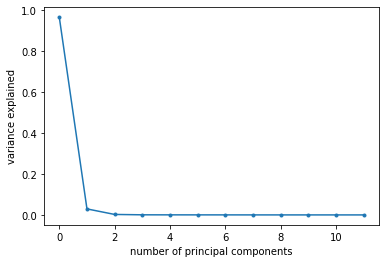

In [17]:
# create PCA estimator
pca = PCA()

features_pca = pca.fit_transform(x)
# Show results
features_pca.shape
# pca = PCA(n_components=x.shape[1], whiten=True)

# variance explained
pca_var_ex = pd.Series(pca.explained_variance_ratio_)

plt.plot(pca_var_ex.index, pca_var_ex, marker = ".")
plt.ylabel("variance explained")
plt.xlabel("number of principal components")
# When we perform a decomposition on, we always emphasize the "most important synthetic features." 
# The result of this for PCA specifically is that, by definition, the variance decreases with each PCA feature.

# There can be a secondary de-emphasis of some features that is too strong. 
# It depends on the specific kind of model used, but for many models a numeric 
# feature ranging from 0 to 100 will simply have more effect than a feature varying 
# from 0 to 1 just because it contributes bigger numbers to the calculation. 
# Usually it is better to let a model select the importances of features than to judge it in advance with feature engineering.

Text(0.5, 1.0, 'PC3')

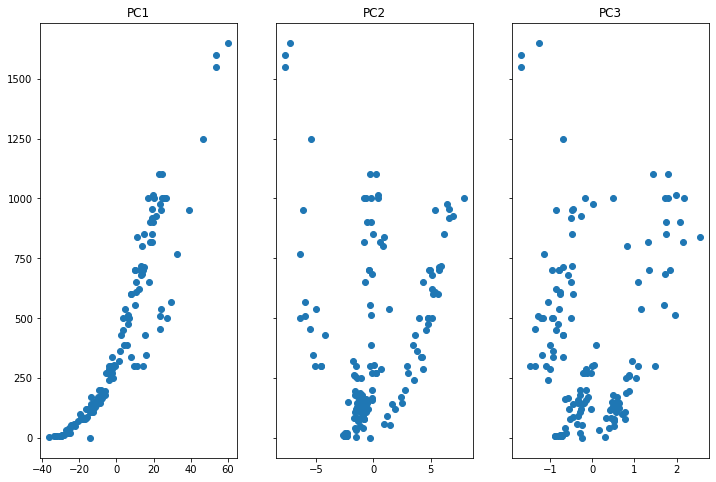

In [18]:
plt.rcParams['figure.figsize'] = [12, 8]   # to have bigger plots

# Create 3 subplots for 3 first PC
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
ax1.scatter(features_pca[:, 0], y)
ax1.set_title('PC1')
ax2.scatter(features_pca[:, 1], y)
ax2.set_title('PC2')
ax3.scatter(features_pca[:, 2], y)
ax3.set_title('PC3')


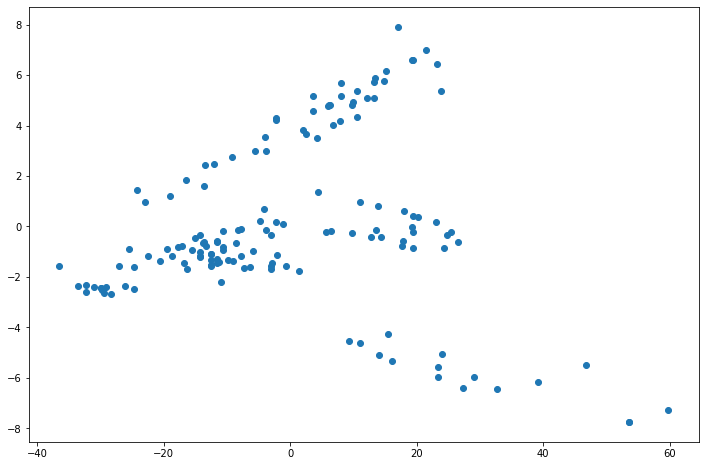

In [19]:
plt.scatter(features_pca[:, 0], features_pca[:, 1])

Text(0.5, 0, 'pca_components')

<Figure size 1440x1080 with 0 Axes>

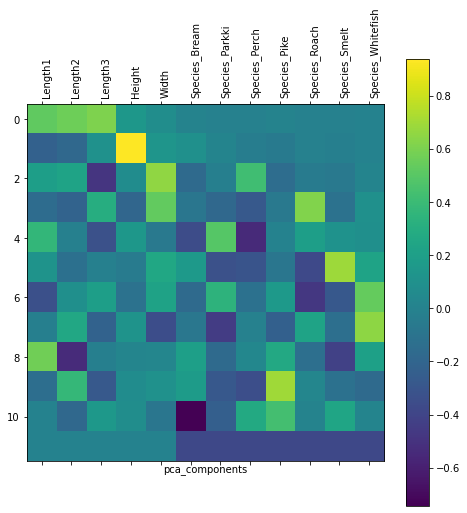

In [20]:
# We can see how the two PCA components are derived by linear combination of the original 30.
pca.components_


# Notice that each components represent an arbitrary combination of all the actual observational measurements in the dataset. 
# Therefore, they do not have any obvious English description other than "first component" and "second component."
# let's plot it
nfeat = x.shape[1]
plt.figure(figsize=(20,15))
plt.matshow(pca.components_[:,:nfeat], cmap='viridis')
# plt.yticks([0, 1], ["first component", "second component"])
plt.colorbar()
plt.xticks(range(nfeat), x.columns, rotation=90, ha='left')
plt.xlabel("pca_components")

Text(0.5, 0, 'number of principal components')

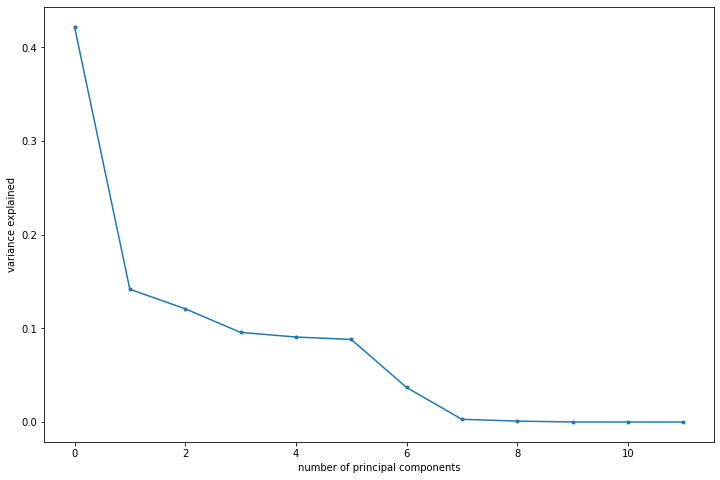

In [21]:
from sklearn.preprocessing import StandardScaler
scaled_x = StandardScaler().fit_transform(x)
scaled_y = (y - y.mean()) / y.std()

# create PCA estimator
pca = PCA()
# Conduct PCA
features_scaled_pca = pca.fit_transform(scaled_x)
# Show results
features_scaled_pca.shape

# variance explained
pca_var_ex = pd.Series(pca.explained_variance_ratio_)

plt.plot(pca_var_ex.index, pca_var_ex, marker = ".")
plt.ylabel("variance explained")
plt.xlabel("number of principal components")


Text(0.5, 1.0, 'PC3')

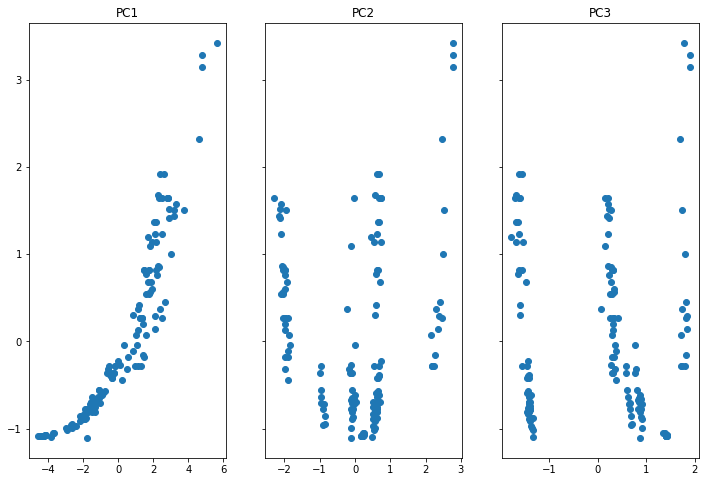

In [680]:
# Create 3 subplots for 3 first PC
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
ax1.scatter(features_scaled_pca[:, 0], scaled_y)
ax1.set_title('PC1')
ax2.scatter(features_scaled_pca[:, 1], scaled_y)
ax2.set_title('PC2')
ax3.scatter(features_scaled_pca[:, 2], scaled_y)
ax3.set_title('PC3')

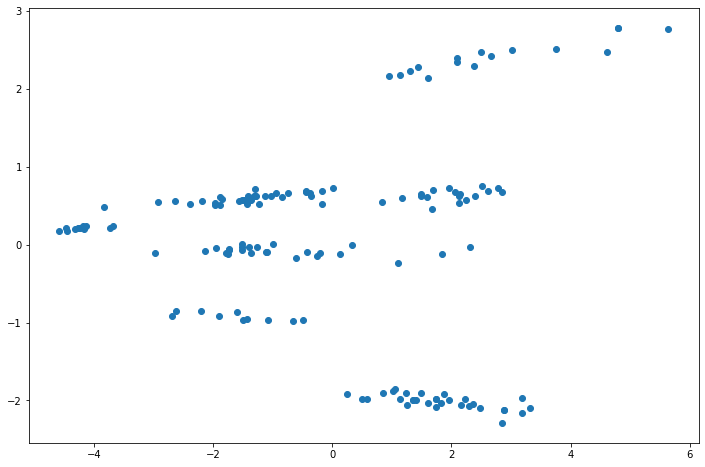

In [681]:
plt.scatter(features_scaled_pca[:, 0], features_scaled_pca[:, 1])

Text(0.5, 0, 'pca_components')

<Figure size 1440x1080 with 0 Axes>

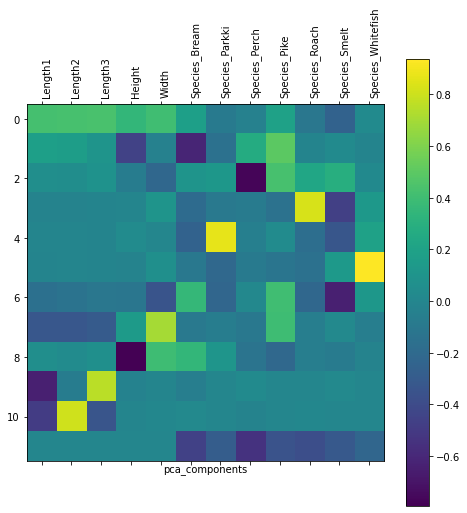

In [22]:
# again composition, bus after scaling
nfeat = x.shape[1]
plt.figure(figsize=(20,15))
plt.matshow(pca.components_[:,:nfeat], cmap='viridis')
# plt.yticks([0, 1], ["first component", "second component"])
plt.colorbar()
plt.xticks(range(nfeat), x.columns, rotation=90, ha='left')
plt.xlabel("pca_components")

# Trying out prediction different models

I will use Stratified 5-fold validation scheme to for choosing of a best model.

Models to try:

* KNN (after optimizing for K value)
* Lasso (after optimizing for tuning parameter)
* Ridge (after optimizing for tuning parameter)
* Linear regression with PC1 and PC2
* linear regression with Width, Height, Species and Length1
* Linear regression with Width, Height, Species and Length1 -- but without outliers



In [566]:
# I already have x with encoded dummy variables and weight in separate y object
scaled_x.shape
scaled_y.shape

# testing set.
x, x_out, y, y_out = train_test_split(scaled_x, scaled_y, test_size = 0.1, random_state = 0)
x_pca, x_out_pca, y, y_out = train_test_split(features_scaled_pca, scaled_y, test_size = 0.1, random_state = 0)

# results:
model_score = {}
# some other variables
n = scaled_x.shape[1]
column = pd.get_dummies(data, columns=["Species"]).drop("Weight", axis = 1).columns

Text(0, 0.5, 'score')

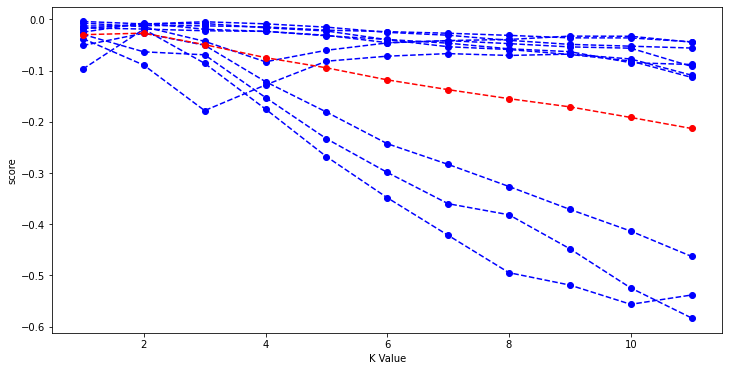

In [567]:
# KNN model
k_range = range(1, n)
all_scores = []
mean_scores = []
# Calculating error for K values between 1 and 12
for i in k_range:
    knn = KNeighborsRegressor(n_neighbors=i)
    scores = cross_val_score(knn, x, y, scoring='neg_mean_squared_error', cv = KFold(10, True, 1))
    all_scores.append(scores)
    mean_scores.append(np.mean(scores))

plt.figure(figsize=(12, 6))
plt.plot(k_range, all_scores, color='blue', linestyle='dashed', marker='o', markerfacecolor='blue')
plt.plot(k_range, mean_scores, color='red', linestyle='dashed', marker='o', markerfacecolor='red')
plt.xlabel('K Value')
plt.ylabel('score')

In [568]:
knn = KNeighborsRegressor(n_neighbors=2)
knn_scores = cross_val_score(knn, x, y, scoring='neg_mean_squared_error', cv = KFold(10, True, 1))
model_score["knn"] = [knn, knn_scores, knn_scores.mean(), knn_scores.std()]

In [569]:
# Lasso
# finding out the parameter
lasso_CVm = LassoCV(cv=KFold(10, True, 1), random_state=0, max_iter = 10000)
lasso_CVm.fit(x, y)

lasso_CVm.coef_
column[lasso_CVm.coef_ != 0] # which coeficents are non-zero
lasso_alpha = lasso_CVm.alpha_

# CV the model with parameter
lasso_m = Lasso(alpha = lasso_alpha, random_state=0, max_iter = 10000)
lasso_scores = cross_val_score(lasso_m, x, y, cv=KFold(10, True, 1), scoring='neg_mean_squared_error')
model_score["lasso"] = [lasso_m, lasso_scores, lasso_scores.mean(), lasso_scores.std(), column[lasso_CVm.coef_ != 0]]

In [570]:
# Ridge
# finding out the parameter
ridge_CVm = RidgeCV(cv=KFold(10, True, 1))
ridge_CVm.fit(x, y)

ridge_CVm.coef_
pd.DataFrame({"coef":ridge_CVm.coef_, "c": column}).sort_values(by = "coef")
ridge_alpha = ridge_CVm.alpha_

# CV the model with parameter
ridge_m = Ridge(alpha = ridge_alpha)
ridge_scores = cross_val_score(ridge_m, x, y, cv=KFold(10, True, 1), scoring='neg_mean_squared_error')
model_score["ridge"] = [ridge_m, ridge_scores, ridge_scores.mean(), ridge_scores.std()]

In [574]:
# linear regression model full
regr = LinearRegression()
regr.fit(x, y)
# LR the model with parameter
regr_scores = cross_val_score(regr, x, y, cv=KFold(10, True, 1), scoring='neg_mean_squared_error')
model_score["lr full"] = [regr, regr_scores, regr_scores.mean(), regr_scores.std()]

# linear regression model with PC
regr_pca = LinearRegression()
regr_pca.fit(x_pca[:, 0:6], y)
# LR the model with parameter
regr_pca_scores = cross_val_score(regr_pca, x, y, cv=KFold(10, True, 1), scoring='neg_mean_squared_error')
model_score["lr_pca"] = [regr_pca, regr_pca_scores, regr_pca_scores.mean(), regr_pca_scores.std(), regr_pca.coef_]

# linear regression model with PC 2
regr_pca = LinearRegression()
regr_pca.fit(x_pca[:, 0:1], y)
# LR the model with parameter
regr_pca_scores = cross_val_score(regr_pca, x, y, cv=KFold(10, True, 1), scoring='neg_mean_squared_error')
model_score["lr_pca_2"] = [regr_pca, regr_pca_scores, regr_pca_scores.mean(), regr_pca_scores.std(), regr_pca.coef_]


{'knn': [KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                      metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                      weights='uniform'),
  array([-0.00874593, -0.00699569, -0.02686646, -0.0190393 , -0.06320657,
         -0.01418085, -0.00888817, -0.01190901, -0.01876759, -0.08914292]),
  -0.026774249350816303,
  0.02599384977954183],
 'lasso': [Lasso(alpha=0.0014706045965648745, copy_X=True, fit_intercept=True,
        max_iter=10000, normalize=False, positive=False, precompute=False,
        random_state=0, selection='cyclic', tol=0.0001, warm_start=False),
  array([-0.05897862, -0.06923322, -0.11969678, -0.10444775, -0.10858619,
         -0.05173586, -0.15796483, -0.04181646, -0.05195956, -0.0586541 ]),
  -0.08230733613088789,
  0.03615598564369535,
  Index(['Length2', 'Length3', 'Species_Bream', 'Species_Parkki', 'Species_Pike',
         'Species_Roach', 'Species_Smelt'],
        dtype='object')],
 'lr full': [LinearRegres

In [593]:
# Lasso with PC
# finding out the parameter
lasso_CVm = LassoCV(cv=KFold(10, True, 1), random_state=0, max_iter = 10000)
lasso_CVm.fit(x_pca, y)

lasso_CVm.coef_
# which coeficents are non-zero
lasso_alpha = lasso_CVm.alpha_

# CV the model with parameter
lasso_m = Lasso(alpha = lasso_alpha, random_state=0, max_iter = 10000)
lasso_scores = cross_val_score(lasso_m, x_pca, y, cv=KFold(10, True, 1), scoring='neg_mean_squared_error')
model_score["lasso PC"] = [lasso_m, lasso_scores, lasso_scores.mean(), lasso_scores.std(), lasso_CVm.coef_ != 0]

{'knn': [KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                      metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                      weights='uniform'),
  array([-0.00874593, -0.00699569, -0.02686646, -0.0190393 , -0.06320657,
         -0.01418085, -0.00888817, -0.01190901, -0.01876759, -0.08914292]),
  -0.026774249350816303,
  0.02599384977954183],
 'lasso': [Lasso(alpha=0.0014706045965648745, copy_X=True, fit_intercept=True,
        max_iter=10000, normalize=False, positive=False, precompute=False,
        random_state=0, selection='cyclic', tol=0.0001, warm_start=False),
  array([-0.05897862, -0.06923322, -0.11969678, -0.10444775, -0.10858619,
         -0.05173586, -0.15796483, -0.04181646, -0.05195956, -0.0586541 ]),
  -0.08230733613088789,
  0.03615598564369535,
  Index(['Length2', 'Length3', 'Species_Bream', 'Species_Parkki', 'Species_Pike',
         'Species_Roach', 'Species_Smelt'],
        dtype='object')],
 'lasso PC': [Lasso(alpha

In [603]:
from sklearn.feature_selection import RFECV
# regression. recursive freature elimination
rfecv = RFECV(estimator=LinearRegression(), step=1, cv=KFold(10, True, 0 ), scoring='neg_mean_squared_error')
rfecv.fit(x, y)
print("Optimal number of features : %d" % rfecv.n_features_)
cols = rfecv.get_support(indices=True)
column[cols]
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

Index(['Length1', 'Length2', 'Length3', 'Species_Pike', 'Species_Smelt'], dtype='object')

In [610]:
# lr with optimal number of features vu RFECV
rfe_lr_scores = cross_val_score(LinearRegression(), x, y, cv=KFold(10, True, 1), scoring='neg_mean_squared_error')
model_score["rfe lr"] = [rfecv, rfe_lr_scores, rfe_lr_scores.mean(), rfe_lr_scores.std(), column[cols]]

array([0.89996142, 0.88015987, 0.92849555, 0.92234618, 0.92951289,
       0.8596408 , 0.8171487 , 0.939582  , 0.93076257, 0.87447614])

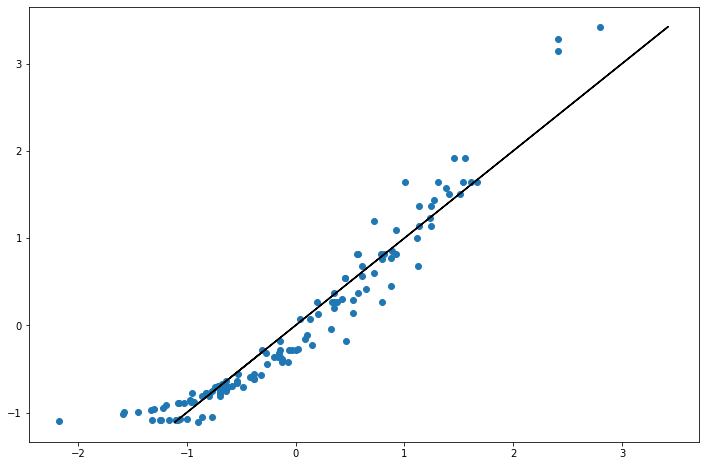

In [658]:
lasso_m.fit(x, y)
y_pred_train = lasso_m.predict(x)
plt.scatter(y_pred_train, y)
plt.plot(y, y,'k-') # identity line

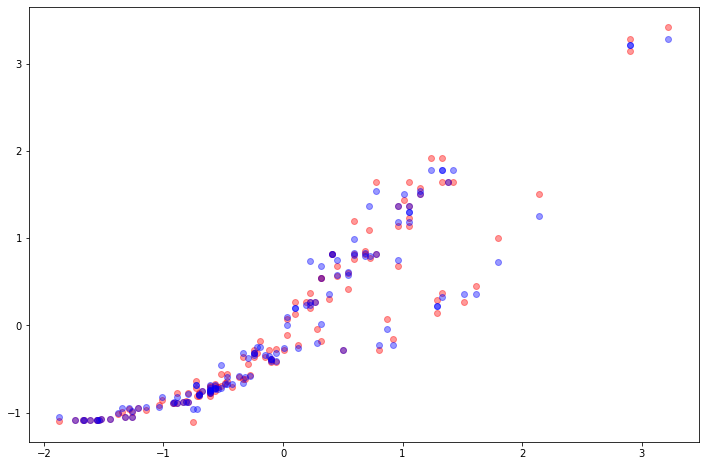

In [654]:
plt.scatter(x[:, 1], y, color='red', alpha=0.4)
plt.scatter(x[:, 1], y_pred_train, color='blue', alpha=0.4)

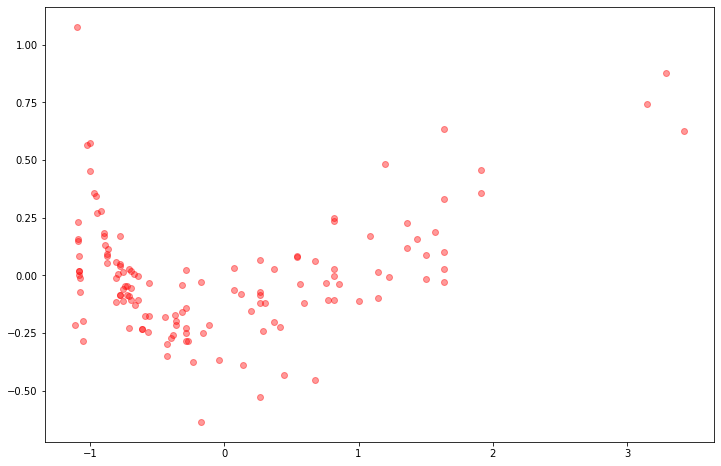

In [659]:
plt.scatter(y, (y - y_pred_train), color='red', alpha=0.4)


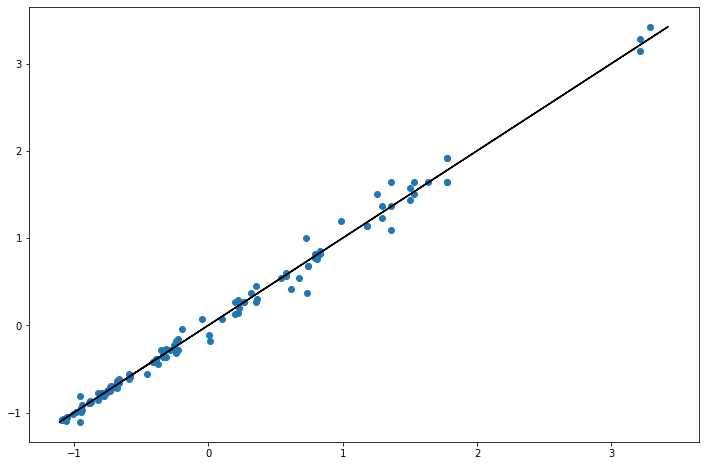

In [660]:
knn.fit(x, y)
y_pred_train = knn.predict(x)
plt.scatter(y_pred_train, y)
plt.plot(y, y,'k-') # identity line


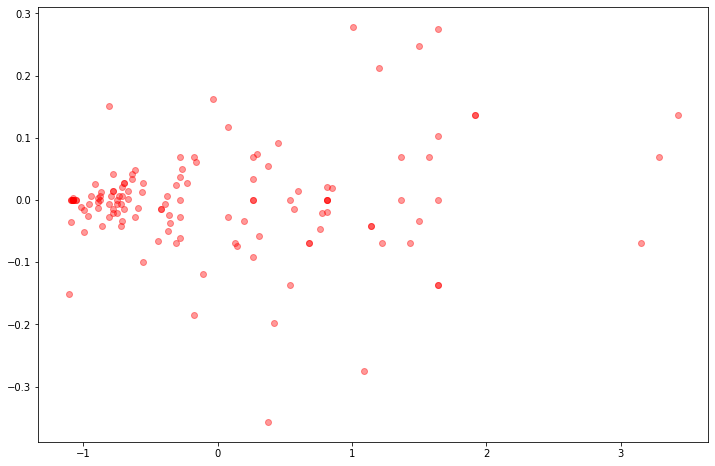

In [662]:
plt.scatter(y, (y - y_pred_train), color='red', alpha=0.4)


In [650]:
# train test value
y_pred_train = knn.predict(x)
((y - y_pred_train)**2).mean()
knn.score(x, y)

# CV test value
knn = KNeighborsRegressor(n_neighbors=2)
knn_scores = cross_val_score(knn, x, y, scoring='neg_mean_squared_error', cv = KFold(10, True, 1))
knn_scores.mean()
knn_scores.std()


# true test value
y_pred_test = knn.predict(x_out)
plt.scatter(y_pred_test, y_out)
plt.plot(y_out, y_out,'k-') # identity line

((y_out - y_pred_test)**2).mean()
knn.score(x_out, y_out)

-0.026774249350816303